In [44]:
from time import strftime,localtime
timestamp=strftime("%Y%m%d_%H%M", localtime())
print(timestamp)

20210831_1133


In [31]:
SHARED="/data/sharing/QuakeCoRE"

import sys

sys.path.append(f"{SHARED}/Ancillary_tools/CPT_Vsz_Vs30")
sys.path.append(f"{SHARED}/Ancillary_tools")
sys.path.append(f"{SHARED}/qcore")

from collections import Counter

import os
import os.path
from pathlib import Path
import yaml


from matplotlib import pyplot as plt
import numpy as np
import pandas as pd


from sqlalchemy import Column, ForeignKey, Integer, String, Float
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship
from sqlalchemy import create_engine, desc
from sqlalchemy.orm import sessionmaker


from getCPTdata import getCPTdata
from computeVs import Vs_McGann
from computeVsz import compute_vsz_from_vs
from computeVs30 import vsz_to_vs30
from loc_filter import locs_multiple_records
from qcore import geo


HOME = Path(os.path.expanduser("~"))
outdir = HOME / f"Data/cpt/outdir/{timestamp}"
plot_dir = out_dir / "validation_plots"

plot_dir.mkdir(parents=True, exist_ok=True)



results = {}



engine = create_engine(f'sqlite:///{SHARED}/Data/nz_cpt.db')
DBSession = sessionmaker(bind=engine)
session = DBSession()
                


def log_error(skipped_fp, cpt_name, error):
    skipped_fp.write(f"{cpt_name} - {error}\n")


def count_digits(arr):
    stringified = str(arr).replace("0", "").replace(".", "")
    return Counter(stringified)


Base = declarative_base()

class CPTLocation(Base):
    __tablename__ = 'cpt_location'
    id = Column(Integer, primary_key=True)
    #    customer_id=Column(Integer, ForeignKey('customers.id'))
    name = Column(String(20), nullable=False)  # 20210427_17
    private = Column(Integer) #true / false
    type = Column(String(5)) # CPT or SCPT
    nztm_x = Column(Float)
    nztm_y = Column(Float)

    def __iter__(self): #overridding this to return tuples of (key,value)
        return iter([('id',self.id),('name',self.name),('nztm_x',self.nztm_x),('nztm_y',self.nztm_y)])


class CPTDepthRecord(Base):
    __tablename__ = 'cpt_depth_record'
    id = Column(Integer, primary_key=True)
    cpt_name = Column(String(20), nullable=False)  # 
    depth = Column(Float) #
    qc = Column(Float) #
    fs = Column(Float)
    u = Column(Float)
    loc_id = Column(Integer, ForeignKey('cpt_location.id'))
    
    def __iter__(self): #overridding this to return tuples of (key,value)
        return iter([('id',self.id),('depth',self.depth),('qc',self.qc),('fs',self.fs),('u',self.u),('loc_id',self.loc_id)])


# not really useful, but presented as an example
def cpt_records(cpt_name):
    res=session.query(CPTDepthRecord).filter(CPTDepthRecord.cpt_name == cpt_name).all()
    return res

# not really useful, but presented as an example
def max_depth_record(cpt_name):
    res=session.query(CPTDepthRecord).filter(CPTDepthRecord.cpt_name == cpt_name).order_by(CPTDepthRecord.depth.desc()).first()
    return res

# the following 3 functions are actually used
def cpt_locations():
    return session.query(CPTLocation).all()

def cpt_records_exists(cpt_name):
    res=session.query(CPTDepthRecord).filter(CPTDepthRecord.cpt_name == cpt_name).first()
    return (res is not None)

def get_cpt_data(cpt_name, columnwise=True):
    res=session.query(CPTDepthRecord.depth,CPTDepthRecord.qc,CPTDepthRecord.fs,CPTDepthRecord.u).filter(CPTDepthRecord.cpt_name == cpt_name).all()
    res_array =np.array(res)
    if columnwise: #each column is grouped together
        res_array = res_array.T
    return res_array
    


# Usage Examples

Check if any record found for a CPT name

In [32]:
print(cpt_records_exists("CPT_108566"))
print(cpt_records_exists("SCPT_140251"))


False
True


In [33]:
get_cpt_data("CPT_108566")


array([], dtype=float64)

Retrieve CPT records for a given CPT

In [34]:
%%time
res=cpt_records('SCPT_140251')
#print(res)
#print(res[0].depth)

CPU times: user 16.3 ms, sys: 5 µs, total: 16.3 ms
Wall time: 16 ms


However, the following function is preferred

In [35]:
depth, qc, fs, u = get_cpt_data("SCPT_140251")

In [36]:
print(depth)

[ 0.03  0.05  0.07 ... 20.65 20.67 20.69]


With `columnwise=False`, each CPT depth record is grouped together as below. `columnwise=True` by default

In [37]:
cpt_records = get_cpt_data("SCPT_140251", columnwise=False)
print(cpt_records[0])

[ 0.03    0.0105  0.0002 -0.0004]


Retrieves all locations

In [38]:
%%time
locs = cpt_locations()
print(dict(locs[0]))


{'id': 1, 'name': 'CPT_1', 'nztm_x': 1576467.294706431, 'nztm_y': 5181262.382226084}
CPU times: user 1.07 s, sys: 35.9 ms, total: 1.1 s
Wall time: 1.1 s


The record at the maximum depth can be retrived by this function. (In practice, this function may not be useful)

In [39]:
%%time
print(dict(max_depth_record('SCPT_140251')))


{'id': 1034, 'depth': 20.69, 'qc': 22.7256, 'fs': 1.0416, 'u': -0.0251, 'loc_id': 39741}
CPU times: user 4.21 ms, sys: 4 µs, total: 4.22 ms
Wall time: 3.44 ms


# Find Duplicate Locations

In [40]:
#dup_locs_dict is a dictionary {loc0:[loc00,loc01],loc1:[loc10,loc11,loc12],loc2:[loc20]...} 
#meaning loc00,loc01 are within 0.1m distance from loc0. It may be too strict.

#computing locs_multiple_records() takes about 5 mins, and I'm skipping here
#if filtering criteria needs to be updated, revise locs_multiple_records() @ loc_filter.py and delete out_dir/dup_locs.yaml

dup_locs_yaml_file = out_dir/"dup_locs.yaml"

if dup_locs_yaml_file.exists():
    with open(out_dir/"dup_locs.yaml", 'r') as f:
        dup_locs_dict = yaml.load(f, Loader=yaml.SafeLoader)
else:        
    dup_locs_dict=locs_multiple_records(locs, stdout=True)
    #let's save this in a yaml file for future use
    with open(out_dir/"dup_locs.yaml","w") as f:
        yaml.safe_dump(dup_locs_dict,f)

    
#flattens dictionary into lists. [loc00,loc01,loc10,loc11,loc12,loc20...]
import functools,operator
dup_locs = functools.reduce(operator.iconcat, list(dup_locs_dict.values()), []) 

#note that loc0,loc1 are not in dup_locs. These locations are to be processed. Duplicates are to be skipped


# Main routine

Loops through all `locs`, and for each location, it performs filtering process. When all the filtering criteria is met, it does conversion from CPT to Vs, Vsz and Vs30

In [41]:
%%time
skipped_fp = open(out_dir / f"skipped_cpts_{timestamp}", "w")
output_file = out_dir / f"vs30_results_{timestamp}.csv"

log_error(skipped_fp, "<<<<<", f"Beginning loop : {timestamp}")
for row_n, loc in enumerate(locs):
    
    cpt_name = loc.name
    if not cpt_records_exists(cpt_name):
        log_error(skipped_fp, cpt_name, f"Type 01 : No record found: {cpt_name}")
        continue
    
    if row_n % 1000 == 0: #print every 1000
        print(f"{row_n+1}/{len(locs)} - {cpt_name}")
    
    z, qc, fs, u2 = get_cpt_data(cpt_name)
     

    # duplicate location
#     if cpt_name in dup_locs:
#         log_error(skipped_fp, cpt_name, f"Type 02 :Duplicate location")
#         continue

    # duplicate depth check
    u, c = np.unique(z, return_counts=True)
    if np.any([c > 1]):
        log_error(skipped_fp, cpt_name, f"Type 03 : Duplicate depth detected - invalid CPT")
        continue

    # Check for invalid negative readings
    if any(fs < -0.2) or any(qc < -0.2) or any(u2 < -0.2):
        log_error(skipped_fp, cpt_name, f"Type 04 : negative value - discarding")
        continue

    # Check for repeated digits
    if any(value > 3 for fs_value in fs for value in count_digits(fs_value).values()):
        log_error(skipped_fp, cpt_name, f"Type 05 : Repeated digit - investigating")
        continue

    max_depth = max(z)
    if max_depth < 20:
        log_error(skipped_fp, cpt_name, f"Type 06 : depth<5: {max_depth}")
        continue
    min_depth = min(z)
    z_span = max_depth - min_depth
    if z_span < 5:
        log_error(skipped_fp, cpt_name, f"Type 07 : depth range <5: {z_span}")
        continue
        
    #All the filtering is complete and this record has survived
    
    (z, Vs, Vs_SD) = Vs_McGann(z, qc, fs)
                                                   
    Vsz, max_depth = compute_vsz_from_vs(Vs, z)
    vs30 = vsz_to_vs30(Vsz, z)

    vs30_result = {}
    vs30_result["NZTM_X"] = loc.nztm_x
    vs30_result["NZTM_Y"] = loc.nztm_y
    vs30_result["Vsz"] = Vsz
    vs30_result["Vs30"] = vs30
    vs30_result["Zmax"] = max_depth
    vs30_result["Zmin"] = min_depth
    vs30_result["Zspan"] = z_span
    results[cpt_name] = vs30_result
    if row_n < 10:
        fig, ax = plt.subplots()
        ax.plot(fs, z)
        ax.invert_yaxis()
        ax.set_ylabel("Depth")
        ax.set_xlabel("fs")
        ax.grid()
        fig.savefig(plot_dir / f"{cpt_name}_fs.png")
        plt.close(fig)

        fig, ax = plt.subplots()
        lowerVs = np.exp(np.log(Vs) - Vs_SD)
        upperVs = np.exp(np.log(Vs) + Vs_SD)
        ax.plot(Vs, z, "red")
        ax.plot(lowerVs, z, "r--", linewidth=0.5)
        ax.plot(upperVs, z, "r--", linewidth=0.5)
        ax.grid()
        ax.invert_yaxis()
        ax.set_ylabel("Depth")
        ax.set_xlabel("Vs (m/s)")
        ax.set_xlim(0, 600)
        fig.savefig(plot_dir / f"{cpt_name}_Vs.png")
        plt.close(fig)

log_error(skipped_fp, ">>>>>", f"Ending loop : {timestamp}")

1/49321 - CPT_1


/data/sharing/QuakeCoRE/Ancillary_tools/CPT_Vsz_Vs30/calculations.py:22: RuntimeWarning: invalid value encountered in true_divide
  tn = dn / vn
/opt/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in log
/opt/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log
/data/sharing/QuakeCoRE/Ancillary_tools/CPT_Vsz_Vs30/calculations.py:22: RuntimeWarning: invalid value encountered in true_divide
  tn = dn / vn
/opt/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in log
/opt/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log
/data/sharing/QuakeCoRE/Ancillary_tools/CPT_Vsz_Vs30/calculations.py:22: RuntimeWarning: invalid value encountered in true_divide
  tn = dn / vn
/opt/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divi

1001/49321 - CPT_103928
3001/49321 - CPT_11089
4001/49321 - CPT_114078
5001/49321 - CPT_117087
6001/49321 - CPT_12186
7001/49321 - CPT_125211
8001/49321 - CPT_128596
9001/49321 - CPT_132681
10001/49321 - CPT_137341
11001/49321 - CPT_141680
12001/49321 - CPT_145879
13001/49321 - CPT_16553
14001/49321 - CPT_19038
15001/49321 - CPT_2146
16001/49321 - CPT_24500
17001/49321 - CPT_26055
18001/49321 - CPT_2792
19001/49321 - CPT_30110
20001/49321 - CPT_32698
21001/49321 - CPT_34626
22001/49321 - CPT_36850
23001/49321 - CPT_38626
24001/49321 - CPT_417
25001/49321 - CPT_45201
26001/49321 - CPT_48331
27001/49321 - CPT_50668
28001/49321 - CPT_55065
29001/49321 - CPT_56472
30001/49321 - CPT_60154
32001/49321 - CPT_72304
33001/49321 - CPT_74578
34001/49321 - CPT_78353
35001/49321 - CPT_86823
36001/49321 - CPT_8930
37001/49321 - CPT_93158
38001/49321 - CPT_95034
40001/49321 - CPT_TT101422
41001/49321 - CPT_TT111947
42001/49321 - CPT_TT133848
43001/49321 - CPT_TT16110
44001/49321 - CPT_TT38531
45001/4

# Save Vs30 Estimates

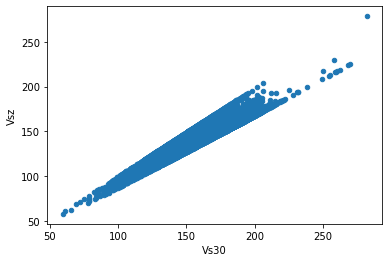

In [42]:
result_df = pd.DataFrame.from_dict(results, orient="index")
result_df.to_csv(output_file)

ll = geo.wgs_nztm2000x(result_df[["NZTM_X", "NZTM_Y"]])
result_df["lon"] = ll[:, 0]
result_df["lat"] = ll[:, 1]

result_df.plot.scatter("Vs30", "Vsz")
fig = plt.gcf()
fig.savefig(plot_dir / "vs30_vsz_scatter.png")

In [43]:
result_df

,NZTM_X,NZTM_Y,Vsz,Vs30,Zmax,Zmin,Zspan,lon,lat
CPT_1,1.576467e+06,5.181262e+06,171.591623,184.625369,25,0.04,25.92,172.708811,-43.521206
CPT_10001,1.570257e+06,5.178666e+06,NaN,NaN,23,0.00,23.34,172.631824,-43.544364
CPT_10003,1.571621e+06,5.179830e+06,NaN,NaN,27,0.00,27.30,172.648774,-43.533931
CPT_10004,1.571595e+06,5.179847e+06,NaN,NaN,27,0.00,27.24,172.648453,-43.533778
CPT_10005,1.570682e+06,5.180753e+06,140.656166,166.268288,20,0.40,19.66,172.637194,-43.525588
...,...,...,...,...,...,...,...,...,...
SCPT_TT95352,1.746063e+06,5.969807e+06,117.616148,131.948219,22,0.01,22.10,174.628946,-36.405812
SCPT_TT95395,1.746175e+06,5.969737e+06,114.611763,128.381392,22,0.01,22.60,174.630211,-36.406429
SCPT_TT95397,1.746216e+06,5.969665e+06,116.340132,127.540454,23,0.06,23.38,174.630677,-36.407065
SCPT_TT95534,1.884410e+06,5.824483e+06,103.600474,111.363323,24,3.91,20.76,176.225116,-37.682789
